In [2]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


In [3]:
!pip install --upgrade scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 50.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
# ---------------------------
# ML Model: Predict Nova Score
# ---------------------------

import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Load dataset
df = pd.read_csv("/content/final_nova_dataset.csv")

# Target
target = 'nova_score'

# Features to drop (ID/time and previous score to avoid leakage)
drop_cols = ['worker_id', 'week', 'nova_prev_score', target]
X = df.drop(columns=drop_cols)
y = df[target]

# Identify categorical features
categorical_features = ['gender', 'region', 'partner_tier', 'worker_type']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize CatBoost Regressor
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

# Train the model
model.fit(X_train, y_train, cat_features=categorical_features, eval_set=(X_test, y_test))

# Predict
y_pred = model.predict(X_test)

# Evaluate
# rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE on test set: {rmse:.4f}")
print(f"R2 Score on test set: {r2:.4f}")

# Feature importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.get_feature_importance()
}).sort_values(by='importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)


0:	learn: 9.9903904	test: 9.5968824	best: 9.5968824 (0)	total: 55.7ms	remaining: 55.6s
100:	learn: 6.7282707	test: 6.4923385	best: 6.4923385 (100)	total: 2.64s	remaining: 23.5s
200:	learn: 6.2720304	test: 6.1459888	best: 6.1459888 (200)	total: 4.14s	remaining: 16.5s
300:	learn: 5.9089207	test: 5.8356308	best: 5.8356308 (300)	total: 5.75s	remaining: 13.3s
400:	learn: 5.6207094	test: 5.6099045	best: 5.6099045 (400)	total: 7.85s	remaining: 11.7s
500:	learn: 5.4128546	test: 5.4510939	best: 5.4510939 (500)	total: 10s	remaining: 9.98s
600:	learn: 5.2383616	test: 5.3300259	best: 5.3300259 (600)	total: 11.7s	remaining: 7.75s
700:	learn: 5.0598983	test: 5.2145167	best: 5.2143642 (699)	total: 14.8s	remaining: 6.31s
800:	learn: 4.9194596	test: 5.1341923	best: 5.1341923 (800)	total: 16.4s	remaining: 4.08s
900:	learn: 4.8000191	test: 5.0709484	best: 5.0709484 (900)	total: 18.1s	remaining: 1.99s
999:	learn: 4.6739364	test: 4.9860918	best: 4.9860044 (998)	total: 19.8s	remaining: 0us

bestTest = 4.986

In [7]:
# ----------------- Imports -----------------
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# ----------------- Load Dataset -----------------
df = pd.read_csv("/content/final_nova_dataset_65_35.csv")

# ----------------- Sensitive & Numeric Features -----------------
sensitive_features = ['gender', 'region']
numeric_features = ['age','earnings','jobs_completed','repeat_client_share','avg_job_value',
                    'hours_worked','dispute_count','tips_share','customer_rating',
                    'cancellation_rate','peak_hour_jobs_share','transaction_count','gap_days']

leakage_cols = ['worker_id', 'nova_score', 'nova_prev_score', 'week']
df_model = df.drop(columns=[c for c in leakage_cols if c in df.columns])

# ----------------- Group-wise Normalization -----------------
df_norm = df.copy()
df_norm['group'] = df_norm[sensitive_features].agg('_'.join, axis=1)

for feature in numeric_features:
    df_norm[feature + '_norm'] = df_norm.groupby('group')[feature].transform(
        lambda x: (x - x.mean()) / (x.std() + 1e-8)
    )

# ----------------- Features & Target -----------------
norm_features = [f + '_norm' for f in numeric_features] + ['gender','region','partner_tier','worker_type']
X = df_norm[norm_features]
y = df_norm['nova_score']
cat_features = ['gender','region','partner_tier','worker_type']

# ----------------- Train-Test Split -----------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------- Sample Weights for Bias Mitigation -----------------
w_train = np.ones(len(X_train))
w_train[(X_train['gender']=='Other')] = 2.0
w_train[(X_train['region']=='West')] *= 1.5

# ----------------- CatBoost Model -----------------
model = CatBoostRegressor(
    iterations=9000,
    learning_rate=0.03,  # lower LR for stability
    depth=7,
    eval_metric='RMSE',
    random_seed=42,
    od_type='Iter',      # use early stopping
    od_wait=200,
    verbose=100
)

# ----------------- Train Model -----------------
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    sample_weight=w_train,
    eval_set=(X_test, y_test)
)

# ----------------- Evaluate -----------------
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}, R2: {r2:.4f}")

# ----------------- Feature Importances -----------------
feat_imp = pd.DataFrame({
    'feature': model.feature_names_,
    'importance': model.get_feature_importance()
}).sort_values('importance', ascending=False)
print("\nFeature Importances:\n", feat_imp)

# ----------------- Fairness Check -----------------
print("\nMean predicted Nova Score by Gender:")
print(pd.DataFrame({'gender': X_test['gender'], 'pred': y_pred}).groupby('gender').mean())

print("\nMean predicted Nova Score by Region:")
print(pd.DataFrame({'region': X_test['region'], 'pred': y_pred}).groupby('region').mean())


0:	learn: 10.8952758	test: 10.8119387	best: 10.8119387 (0)	total: 45.1ms	remaining: 6m 45s
100:	learn: 7.0594511	test: 7.1125722	best: 7.1125722 (100)	total: 2.78s	remaining: 4m 5s
200:	learn: 6.6431287	test: 6.8039031	best: 6.8039031 (200)	total: 8.68s	remaining: 6m 19s
300:	learn: 6.2866164	test: 6.5221365	best: 6.5221365 (300)	total: 14.7s	remaining: 7m 4s
400:	learn: 5.8869018	test: 6.1937810	best: 6.1937810 (400)	total: 18.5s	remaining: 6m 37s
500:	learn: 5.6222741	test: 5.9766932	best: 5.9766932 (500)	total: 22.2s	remaining: 6m 16s
600:	learn: 5.4230775	test: 5.8200286	best: 5.8200286 (600)	total: 24.6s	remaining: 5m 43s
700:	learn: 5.2544233	test: 5.6890103	best: 5.6890103 (700)	total: 26.9s	remaining: 5m 18s
800:	learn: 5.0652730	test: 5.5327995	best: 5.5327995 (800)	total: 29.2s	remaining: 4m 59s
900:	learn: 4.9131747	test: 5.4234353	best: 5.4233448 (899)	total: 31.6s	remaining: 4m 44s
1000:	learn: 4.7640326	test: 5.3137950	best: 5.3137950 (1000)	total: 35.3s	remaining: 4m 42s

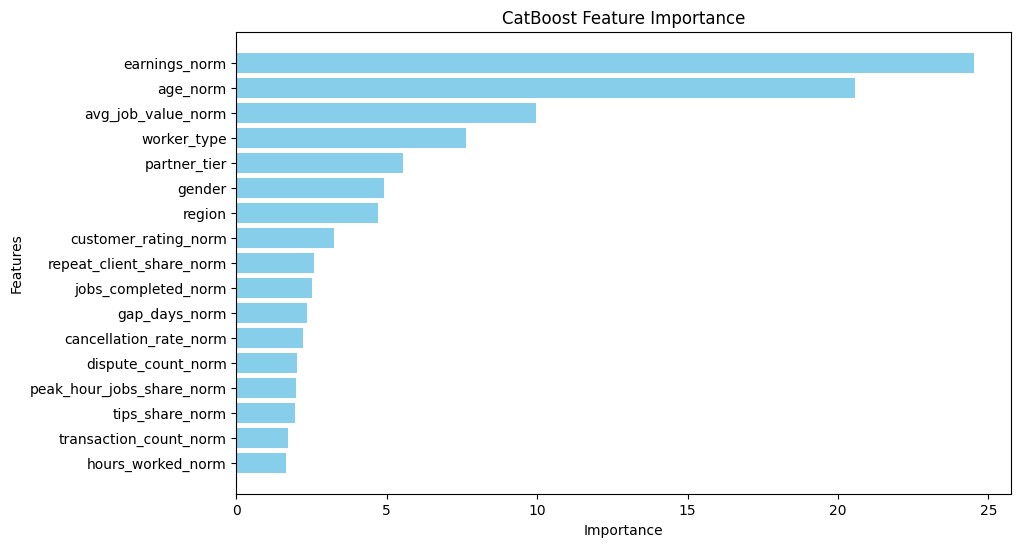

In [9]:
import matplotlib.pyplot as plt

# ----------------- Feature Importance (Overall) -----------------
feat_imp = pd.DataFrame({
    'feature': model.feature_names_,
    'importance': model.get_feature_importance()
}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()


In [11]:
# ----------------- Save CatBoost model -----------------
model.save_model("catboost_model.cbm")  # CatBoost native format

# (Optional) also save feature names for reference
import joblib
joblib.dump(X_train.columns.tolist(), "catboost_features.pkl")

print("✅ Model and features saved")


✅ Model and features saved


In [12]:
from catboost import CatBoostRegressor
import joblib
import pandas as pd

# Load model
cat_model = CatBoostRegressor()
cat_model.load_model("catboost_model.cbm")

# Load features (for alignment)
cat_features = joblib.load("catboost_features.pkl")

print("✅ Model and features loaded")


✅ Model and features loaded


In [13]:
# Suppose you have a new dataset
new_df = pd.read_csv("/content/final_nova_dataset_65_35.csv")

# Drop leakage cols if present
leakage_cols = ['worker_id', 'nova_score', 'nova_prev_score', 'week']
new_df = new_df.drop(columns=[c for c in leakage_cols if c in new_df.columns])

# Recreate group column for normalization
sensitive_features = ['gender', 'region']
numeric_features = ['age','earnings','jobs_completed','repeat_client_share','avg_job_value',
                    'hours_worked','dispute_count','tips_share','customer_rating',
                    'cancellation_rate','peak_hour_jobs_share','transaction_count','gap_days']

new_df['group'] = new_df[sensitive_features].agg('_'.join, axis=1)

# Apply same normalization
for feature in numeric_features:
    new_df[feature + '_norm'] = new_df.groupby('group')[feature].transform(
        lambda x: (x - x.mean()) / (x.std() + 1e-8)
    )

# Final feature set (must match training features)
X_new = new_df[cat_features]


In [14]:
# Run predictions
predictions = cat_model.predict(X_new)

# Attach predictions back to dataframe
new_df["catboost_predicted_score"] = predictions

print(new_df[["catboost_predicted_score"]].head())


   catboost_predicted_score
0                 77.283984
1                 69.797684
2                 68.131501
3                 71.487918
4                 68.897535


In [17]:
raw_df = pd.read_csv("/content/final_nova_dataset_65_35.csv")  # original data with all columns
raw_df["catboost_predicted_score"] = predictions
raw_df.to_csv("catboost_predicted_score.csv", index=False)


In [18]:
pred_df = pd.read_csv("/content/catboost_predicted_score.csv")
print(pred_df.head())

   worker_id  week  age gender region partner_tier worker_type  earnings  \
0          0     4   33      M  North       silver    merchant   1416.67   
1          0     5   33      M  North       silver    merchant   1486.81   
2          0     6   33      M  North       silver    merchant   1608.10   
3          0     7   33      M  North       silver    merchant   1498.12   
4          0     8   33      M  North       silver    merchant   1779.19   

   jobs_completed  repeat_client_share  ...  dispute_count  tips_share  \
0               7                 0.93  ...              0        0.26   
1              12                 0.39  ...              0        0.19   
2              14                 0.22  ...              0        0.14   
3               8                 0.18  ...              0        0.16   
4              11                 0.37  ...              0        0.35   

   customer_rating  cancellation_rate  peak_hour_jobs_share  \
0         4.916885           0.0706